# drive.mount()

In [37]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [38]:
!pip install imutils

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from imutils import paths
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import pandas as pd
import numpy as np
import copy
import random
import shutil
import cv2
import os
import time
from datetime import datetime

# efficientNet:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

# set random seed so we get the same sampling every time for reproducibility
random_seed = 2020
torch.manual_seed(random_seed);


# Data Preparations - Utils

In [40]:
# Function for plotting samples
def plot_samples(f_samples):  
    """
    plot out multiple samples.
    Args:   
        f_samples - samples created with random.sample() from data diretory
    """    
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(f_samples)):
        image = cv2.cvtColor(imread(f_samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

In [41]:
# function for plotting out some images with their labels. 
%matplotlib inline 
def show_example(f_img, f_label, f_dataset):
    """ 
    plot out some images with their labels. 
    Args:  
        f_img, f_label - some example from dataset
        f_dataset - dataset created with ImageFolder
    """

    print('Label: ', f_dataset.classes[f_label], "("+str(f_label)+")")
    plt.imshow(f_img.permute(1, 2, 0))

In [42]:
# visualize a batch of data in a grid.
#       using the make_grid function from torchvision, and using the .permute method on the tensor 
#       to move the channels to the last dimension, as expected by matplotlib.
def show_batch(f_dl):
    """
    visualize a batch of data in a grid.
    args: 
        f_dl - dataloader, we visualize a batch from this dataloader. 
    """
    for images, labels in f_dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break

# Data Preparation

>This dataset is well structured for most deep learning frameworks. It is organized into train, val, and test folders, which contains subfolders of the classes of pneumonia (normal, pneumonia), each containing the respective jpeg images.




In [43]:
data_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/dataset'

print("directories in data_dir:", os.listdir(data_dir))

print("classes in data_dir_train:", os.listdir(data_dir + "/train"))
print()
pneumonia_files_train = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files_train))
normal_files_train = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal:', len(normal_files_train))

# lets take a look on the train and how the folder orgenized:
print("\n",'lets take a look on the train/PNEUMONIA and how the folder orgenized:')
print(pneumonia_files_train[:5])
print("\n",'lets take a look on the train/NORMAL and how the folder orgenized:')
print(normal_files_train[:5])


directories in data_dir: ['val', 'train', 'test']
classes in data_dir_train: ['PNEUMONIA', 'NORMAL']

No. of training examples for Pneumonia: 3875
No. of training examples for Normal: 1341

 lets take a look on the train/PNEUMONIA and how the folder orgenized:
['person534_bacteria_2251.jpeg', 'person533_bacteria_2250.jpeg', 'person537_bacteria_2262.jpeg', 'person563_bacteria_2335.jpeg', 'person590_virus_1138.jpeg']

 lets take a look on the train/NORMAL and how the folder orgenized:
['IM-0523-0001-0002.jpeg', 'IM-0511-0001.jpeg', 'IM-0520-0001.jpeg', 'IM-0513-0001.jpeg', 'IM-0519-0001.jpeg']


## Create train dataset.
> Notice the data augmentation being applied. 
During training, this image might be transformed to this form, but in another epoch, this image will receive another random transformation, and this DIVERSIFIES the dataset, since the model is not receiving each image in the same 'form' every epoch.

In [44]:
# define pre-processing steps on images
data_transorm_train = tt.Compose([tt.Resize(255),
                              tt.CenterCrop(224),
                              tt.RandomHorizontalFlip(),
                              tt.RandomRotation(10),
                              tt.RandomGrayscale(),
                              tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                              tt.ToTensor()
                              #tt.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] ,inplace=True)
                              ])

# create train dataset:
dataset_train = ImageFolder(data_dir + "/train", data_transorm_train)
print("classes in train dataset:",dataset_train.classes,"\n")
print("train dataset:","\n")
print(dataset_train)


classes in train dataset: ['NORMAL', 'PNEUMONIA'] 

train dataset: 

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /content/drive/MyDrive/DL/project_ariel_yael/pneumonia/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
           )


## statisics and visualizations

In [45]:
# Let's look at an example of an image in its tensor form. Note that after being loaded, 
# each image is now [3, 224, 224], with 3 being the RGB channels
img, label = dataset_train[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [46]:
# plot out some images with their labels.

##############################################
# disable will training for efficiency
##############################################
"""
show_example(*dataset_train[4], dataset_train) 
"""

'\nshow_example(*dataset_train[4], dataset_train) \n'

In [47]:
# number of images for each class

##############################################
# disable will training for efficiency
##############################################
"""
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()
"""

"\ntrain_samplesize = pd.DataFrame.from_dict(\n    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) \n                     for filename in os.listdir(data_dir+'/train/NORMAL')])], \n     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) \n                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})\n\n\nsns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)\nplt.show()\n"

In [48]:
## Plot training samples

##############################################
# disable will training for efficiency
##############################################
"""
rand_samples_train = random.sample([os.path.join(data_dir+'/train/NORMAL', filename) 
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples_train)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()
"""

"\nrand_samples_train = random.sample([os.path.join(data_dir+'/train/NORMAL', filename) \n                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) +     random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename) \n                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)\n\nplot_samples(rand_samples_train)\nplt.suptitle('Training Set Samples', fontsize=30)\nplt.show()\n"

## Split into Train & Validation Data
> Split training dataset into (80%)train and (20%)validation.
* **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
* **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
* **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.
    * the test set will be defined later

In [49]:
# Split training dataset to train and validation
train_size = round(len(dataset_train)*0.8) # 80%
val_size = len(dataset_train) - train_size # 20%

train_ds, val_ds = random_split(dataset_train, [train_size, val_size])

print("number of samples in dataset:\n", "train_ds:", len(train_ds), "val_ds:", len(val_ds))

number of samples in dataset:
 train_ds: 4173 val_ds: 1043


## Create dataloaders
> **batch size:** Here we select a batch size of 32 to perform mini_batch gradient descent/or other optimizers. This is a hyperparameter that can be tuned. The batch size means that the 4173 train images will be divided into batches of 32 images and gradient descent will be performed on each of this 32 images in one epoch (1 runthrough of the whole data).



In [50]:
# hyperparameter: batch zise
batch_size_train=32

# create dataloaders
train_dataloader = DataLoader(train_ds, batch_size_train, shuffle=True, num_workers=2, pin_memory=True) 
val_dataloader = DataLoader(val_ds, batch_size_train*2,shuffle=False, num_workers=2, pin_memory=True) 


# device

In [51]:
# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Utils

## printTime()

In [52]:
def printTime(f_startTime) : 
    """
    Print time elapsed since f_startTime
    """
    f_epochIter_time = time.time() - f_startTime
    print("time : {:.2f} secs".format(f_epochIter_time))

## getDateTimeString()

In [53]:
def getDateTimeString() :
    """
    get the date and time as a string, use for checkpoints.
    """
    # datetime object containing current date and time
    now = datetime.now()

    # dd/mm/YY H:M:S
    dt_string = now.strftime("%Y-%m-%d_%H:%M")
    return "time:" + dt_string


## set_parameter_requires_grad()


> The following helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting.
By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are **training from scratch or finetuning**.
However, if we are **feature extracting** and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients.

In [54]:
def set_parameter_requires_grad(f_model, f_feature_extracting=False):
    """
    Set Model Parameters’ .requires_grad attribute
    Args:
        f_model - the pretrained model
        f_feature_extracting - False when we are feature extracting
                             - True when we are training from scratch or finetuning.
    """
    if f_feature_extracting:
        for param in f_model.parameters():
            param.requires_grad = False
    else:
        for param in f_model.parameters():
            param.requires_grad = True

## gather_params_to_update()

> The following helper function Gather the parameters to be optimized/updated in this run. If we are fine-tuning we will be updating all parameters. if we are doing feature extract method, we will only update the parameters that we have just initialized, i.e. the parameters with requires_grad is True.


In [55]:
def gather_params_to_update(f_model, f_feature_extracting):
  """ 
  Gather the parameters to be optimized/updated in this run
  Args:
        f_model - the pretrained model
        f_feature_extracting - False when we are feature extracting
                             - True when we are training from scratch or finetuning.

  return: list of parameters to be optimized.
        (when feature extracting this list should be short and only include 
        the weights and biases of the reshaped layers.)
  """
  f_params_to_update = f_model.parameters()
  print("Params to learn:")
  if f_feature_extracting:
      f_params_to_update = []
      for name,param in f_model.named_parameters():
          if param.requires_grad == True:
              f_params_to_update.append(param)
              print("\t",name)
  else:
      for name,param in f_model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)
  return f_params_to_update 

## plot_acc_and_loss()

In [56]:
# Plot Accuracy and Loss according to the history
def plot_acc_and_loss(f_number_of_epochs, f_history, f_header = ""):
    """
    plots of the accuracy and loss for the training and validation data. 
    This gives us an idea of how our model is performing (e.g., underfitting, overfitting).

    Args:
        f_number_of_epochs - number of elements in each history
        f_history - {'train_loss','train_acc','val_loss','val_acc'}
        f_header - header to print
    """

    f, (f_ax1, f_ax2) = plt.subplots(1, 2, figsize=(25, 5))
    t = f.suptitle('Performance'+"\n"+f_header, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    f_epoch_list = list(range(1,f_number_of_epochs+1))
    f_ax1.plot(f_epoch_list, f_history['train_acc'], label='Train Accuracy')
    f_ax1.plot(f_epoch_list, f_history['val_acc'], label='Validation Accuracy')
    f_ax1.set_xticks(np.arange(0, f_number_of_epochs+1, 1))
    f_ax1.set_ylabel('Accuracy Value')
    f_ax1.set_xlabel('Epoch')
    f_ax1.set_title('Accuracy')
    l1 = f_ax1.legend(loc="best")

    f_ax2.plot(f_epoch_list, f_history['train_loss'], label='Train Loss')
    f_ax2.plot(f_epoch_list, f_history['val_loss'], label='Validation Loss')
    f_ax2.set_xticks(np.arange(0, f_number_of_epochs+1, 1))
    f_ax2.set_ylabel('Loss Value')
    f_ax2.set_xlabel('Epoch')
    f_ax2.set_title('Loss')
    l2 = f_ax2.legend(loc="best")

## plot_acc_and_loss_for_train_and_val()

In [57]:
# Plot Accuracy and Loss according to the history
def plot_acc_and_loss_for_train_and_val( f_history, f_header= ""):
    """
    plots of the accuracy and loss for the training and validation data. 
    This gives us an idea of how our model is performing (e.g., underfitting, overfitting).

    Args:
        f_history - {'train_loss','train_acc','val_loss','val_acc'}
        f_header - header to print
    """
    f_number_of_epochs = len(f_history['train_acc'])

    f, (f_ax1, f_ax2) = plt.subplots(1, 2, figsize=(25, 5))
    t = f.suptitle('Performance'+"\n"+f_header, fontsize=12)
    f.subplots_adjust(top=0.8, wspace=0.3)

    f_epoch_list = list(range(1,f_number_of_epochs+1))
    # plot train and validation accuracy on the same subplot
    f_ax1.plot(f_epoch_list, f_history['train_acc'], label='Train Accuracy')
    f_ax1.plot(f_epoch_list, f_history['val_acc'], label='Validation Accuracy')
    f_ax1.set_xticks(np.arange(0, f_number_of_epochs+1, 5))
    f_ax1.set_ylabel('Accuracy Value')
    f_ax1.set_xlabel('Epoch')
    f_ax1.set_title('Accuracy')
    l1 = f_ax1.legend(loc="best")

     # plot train and validation loss on the same subplot
    f_ax2.plot(f_epoch_list, f_history['train_loss'], label='Train Loss')
    f_ax2.plot(f_epoch_list, f_history['val_loss'], label='Validation Loss')
    f_ax2.set_xticks(np.arange(0, f_number_of_epochs+1, 5))
    f_ax2.set_ylabel('Loss Value')
    f_ax2.set_xlabel('Epoch')
    f_ax2.set_title('Loss')
    l2 = f_ax2.legend(loc="best")

## plot_multiple_acc_and_loss()

In [58]:
#preperations: must dune before calling the function:
run_preperation = False
if run_preperation : 
    #checkpoint_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_ver3'

    hist_file_name_list = []
    hist_file_name_list_lr001 = []
    hist_file_name_list_lr001_loss = []
    hist_file_name_list_lr001_acc = []
    hist_file_name_list_lr0001 = []
    hist_file_name_list_lr0001_loss = []
    hist_file_name_list_lr0001_acc = []
    # history = {'train_loss','train_acc','val_loss','val_acc'} saved in checkpoint_dir with suffix '__hist.pth'
    checkpints_hist_to_print_dir = checkpoint_dir
    checkpints_hist_to_print_files = os.listdir(checkpints_to_print_dir)
    


    for file_name in checkpints_hist_to_print_files:
        if '__hist.pth' in file_name:
            if '0.001__' in file_name:
                hist_file_name_list_lr001.append(file_name)

                curHist = torch.load(checkpoint_dir + '/' + file_name)
                hist_file_name_list_lr001_loss.append(curHist['val_loss'])
                hist_file_name_list_lr001_acc.append(curHist['val_acc'])

            elif '0.0001__' in file_name:
                hist_file_name_list_lr0001.append(file_name)   

                curHist = torch.load(checkpoint_dir + '/' + file_name)
                hist_file_name_list_lr0001_loss.append(curHist['val_loss'])
                hist_file_name_list_lr0001_acc.append(curHist['val_acc'])

    plot_multiple_acc_and_loss( hist_file_name_list_lr001_loss,hist_file_name_list_lr001_acc, hist_file_name_list_lr001, header= 'performance when changin the model, when LR = LR = 0.001')
    plot_multiple_acc_and_loss( hist_file_name_list_lr0001_loss,hist_file_name_list_lr0001_acc, hist_file_name_list_lr0001, header= 'performance when changin the model, when LR = LR = 0.0001')


def plot_multiple_acc_and_loss( f_list_of_hestory_loss,f_list_of_hestory_acc_acc,f_hist_file_name_list, f_header= ""):
    f, (f_ax1, f_ax2) = plt.subplots(1, 2, figsize=(15, 4))
    t = f.suptitle('Performance'+"\n"+f_header, fontsize=10)
    f.subplots_adjust(top=0.95, wspace=0.3)

    f_num_epochs = len(f_list_of_hestory_loss[0])
    f_epoch_list = list(range(1,f_num_epochs+1))
    f_number_of_plots = len(f_hist_file_name_list)
    for i in range(f_number_of_plots):
        tmp1 = f_hist_file_name_list[i].split("__",2)[2] 
        tmp2 = tmp1.split("__hist",1)[0] 

        f_ax2.plot(f_epoch_list, f_list_of_hestory_loss[i], label=tmp2 )
        f_ax1.plot(f_epoch_list, f_list_of_hestory_acc_acc[i], label=tmp2)

    f_ax1.set_xticks(np.arange(0, f_num_epochs+1, 5))
    f_ax1.set_ylabel('Accuracy Value')
    f_ax1.set_xlabel('Epoch')
    f_ax1.set_title('Accuracy')
    l1 = f_ax1.legend(fontsize=8, loc="lower right")

    f_ax2.set_xticks(np.arange(0, f_num_epochs+1, 5))
    f_ax2.set_ylabel('Loss Value')
    f_ax2.set_xlabel('Epoch')
    f_ax2.set_title('Loss')
    l2 = f_ax2.legend(fontsize=8, loc="upper right")

    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend(fontsize=8)
    
    # To load the display window
    plt.show()

# Model Functions

## intialize the model

> the following function used to compare between the pretrained models :
* efficientnet-b0
* resnet
* alexnet
* vgg
* squeezenet
* densenet

> We load each of the models, setting the pretrained parameter to true to load the pretrained weights. We then freeze the starting layers of the network (except the fully connected layer) and replaced the last layer (fc) with our own as our output has only 2 classes, where the pretained model was trained to output more classes (most of them 1000 classes).*italicized text*


## initialize_model_old()

In [59]:
def initialize_model_old(f_model_name, f_use_pretrained, f_feature_extract):
    print("initialize_model parameters:")
    print("         model_name:", f_model_name , "use_pretrained:", f_use_pretrained, "feature_extract:", f_feature_extract)

    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    f_model_ft = None
    f_num_classes = 2 # normal. pneumonia
    f_input_size = 0  # image size, e.g. (3, 224, 224)

    if f_model_name == 'efficientnet-b0':
        """ Efficientnet-b0
        """
        f_model_ft = EfficientNet.from_pretrained(f_model_name)
        set_parameter_requires_grad(f_model_ft, f_feature_extract)
        num_ftrs = f_model_ft._fc.in_features 
        f_model_ft._fc = nn.Linear(num_ftrs, f_num_classes) # replace the last FC layer
        f_input_size = 224 # for b0: input_size = 224
        

    elif f_model_name == "resnet":
        """ Resnet18
        """
        f_model_ft = models.resnet18(pretrained=f_use_pretrained)
        set_parameter_requires_grad(f_model_ft, f_feature_extract)
        num_ftrs = f_model_ft.fc.in_features
        f_model_ft.fc = nn.Linear(num_ftrs, f_num_classes) # replace the last FC layer
        f_input_size = 224

    elif f_model_name == "alexnet":
        """ Alexnet
        """
        f_model_ft = models.alexnet(pretrained=f_use_pretrained)
        set_parameter_requires_grad(f_model_ft, f_feature_extract)
        num_ftrs = f_model_ft.classifier[6].in_features
        f_model_ft.classifier[6] = nn.Linear(num_ftrs, f_num_classes)
        f_input_size = 224

    elif f_model_name == "vgg":
        """ VGG16
        """
        f_model_ft = models.vgg16(pretrained=f_use_pretrained)
        set_parameter_requires_grad(f_model_ft, f_feature_extract)
        num_ftrs = f_model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, f_num_classes)
        f_input_size = 224

    elif f_model_name == "squeezenet":
        """ Squeezenet
        """
        f_model_ft = models.squeezenet1_0(pretrained=f_use_pretrained)
        set_parameter_requires_grad(f_model_ft, f_feature_extract)
        f_model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        f_model_ft.f_num_classes = f_num_classes
        f_input_size = 224

    elif f_model_name == "densenet":
        """ Densenet
        """
        f_model_ft = models.densenet121(pretrained=f_use_pretrained)
        set_parameter_requires_grad(f_model_ft, f_feature_extract)
        num_ftrs = f_model_ft.classifier.in_features
        f_model_ft.classifier = nn.Linear(num_ftrs, f_num_classes)
        f_input_size = 224

    else:
        raise NotImplementedError

    return f_model_ft, f_input_size

## initialize_model()

the following function initialize model.
after choosing Efficientnet-b0 as the pretrained model, 
* we tested 5 versions for the classifier we train - the layers replacing the last fc of the pretrained model. 
    * The versions differ by their depth (the number of fully connected layers)
* We tried to use different activation functions and chosen to work with LeakyReLU, with a slope of 0.1
* We tested the effect of batch normalization and decided to use it.

In [60]:
def initialize_model(f_model_name, f_use_pretrained, f_feature_extract, f_chooseLong = 0):
 
    print("initialize_model parameters:")
    print("model_name:", f_model_name , "use_pretrained:", f_use_pretrained, "feature_extract:", f_feature_extract, "chooseLong:",f_chooseLong)

    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    f_model_ft = None
    f_num_classes = 2 # normal. pneumonia
    f_input_size = 0  # image size, e.g. (3, 224, 224)

    if f_model_name == 'efficientnet-b0':
        """ Efficientnet-b0
        """
        f_model_ft = EfficientNet.from_pretrained(f_model_name)
        set_parameter_requires_grad(f_model_ft, f_feature_extract)
        # replace model classifier
        num_ftrs = f_model_ft._fc.in_features 

        
        if f_chooseLong == 0 :
            f_model_ft._fc = nn.Linear(num_ftrs, f_num_classes) # replace the last FC layer

        elif f_chooseLong == 1 :
            f_model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, 256),   
                                        nn.LeakyReLU(0.1),
                                        nn.Dropout(0.25),   
                                        nn.Linear(256, 64),
                                        nn.BatchNorm1d(64),
                                        nn.LeakyReLU(0.1),  
                                        nn.Linear(64, f_num_classes)) # replace the last FC layer
        elif f_chooseLong == 2 :
            f_model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, 512),   
                                        nn.LeakyReLU(0.1),
                                        nn.Dropout(0.25),   
                                        nn.Linear(512, 128), 
                                        nn.BatchNorm1d(128), 
                                        nn.LeakyReLU(0.1),  
                                        nn.Linear(128, 64),
                                        nn.BatchNorm1d(64), 
                                        nn.LeakyReLU(0.1),                                          
                                        nn.Linear(64,f_num_classes))         
        elif f_chooseLong == 3 :
            f_model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, 512),   
                                        nn.LeakyReLU(0.1),
                                        nn.Dropout(0.25),   
                                        nn.Linear(512, 128), 
                                        nn.BatchNorm1d(128),
                                        nn.LeakyReLU(0.1),  
                                        nn.Linear(128, 64), 
                                        nn.LeakyReLU(0.1),                                        
                                        nn.Linear(64,32),
                                        nn.BatchNorm1d(32), 
                                        nn.LeakyReLU(0.1),     
                                        nn.Linear(32,f_num_classes))             
        elif f_chooseLong == 4 :
            f_model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, 512),     
                                        nn.LeakyReLU(0.1),
                                        nn.Dropout(0.25),   
                                        nn.Linear(512, 256),
                                        nn.BatchNorm1d(256), 
                                        nn.LeakyReLU(0.1),  
                                        nn.Linear(256, 128), 
                                        nn.LeakyReLU(0.1),    
                                        nn.Linear(128, 64),
                                        nn.BatchNorm1d(64),     
                                        nn.LeakyReLU(0.1),                              
                                        nn.Dropout(0.1), 
                                        nn.Linear(64,32), 
                                        nn.LeakyReLU(0.1),
                                        nn.Linear(32,f_num_classes))
    else:
        raise NotImplementedError

    return f_model_ft, f_input_size

In [61]:
def initialize_model_3_relu(f_model_name, f_use_pretrained, f_feature_extract, f_chooseLong = 3):
 
    print("initialize_model parameters:")
    print("model_name:", f_model_name , "use_pretrained:", f_use_pretrained, "feature_extract:", f_feature_extract, "chooseLong:",f_chooseLong)

    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    f_model_ft = None
    f_num_classes = 2 # normal. pneumonia
    f_input_size = 0  # image size, e.g. (3, 224, 224)

    if f_model_name == 'efficientnet-b0':
        """ Efficientnet-b0
        """
        f_model_ft = EfficientNet.from_pretrained(f_model_name)
        set_parameter_requires_grad(f_model_ft, f_feature_extract)
        # replace model classifier
        num_ftrs = f_model_ft._fc.in_features 

        
        if f_chooseLong == 0 :
            print()
      
        elif f_chooseLong == 3 :
            f_model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, 512),   
                                        nn.ReLU(),
                                        nn.Dropout(0.25),   
                                        nn.Linear(512, 128), 
                                        nn.ReLU(),  
                                        nn.Linear(128, 64), 
                                        nn.ReLU(),                                        
                                        nn.Linear(64,32),
                                        nn.ReLU(),    
                                        nn.Linear(32,f_num_classes))             

    else:
        raise NotImplementedError

    return f_model_ft, f_input_size

In [62]:
def initialize_model_3_LeakyRelu_noBatchNorm(f_model_name, f_use_pretrained, f_feature_extract, f_chooseLong = 3):
 
    print("initialize_model parameters:")
    print("model_name:", f_model_name , "use_pretrained:", f_use_pretrained, "feature_extract:", f_feature_extract, "chooseLong:",f_chooseLong)

    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    f_model_ft = None
    f_num_classes = 2 # normal. pneumonia
    f_input_size = 0  # image size, e.g. (3, 224, 224)

    if f_model_name == 'efficientnet-b0':
        """ Efficientnet-b0
        """
        f_model_ft = EfficientNet.from_pretrained(f_model_name)
        set_parameter_requires_grad(f_model_ft, f_feature_extract)
        # replace model classifier
        num_ftrs = f_model_ft._fc.in_features 

        
        if f_chooseLong == 0 :
            print()
      
        elif f_chooseLong == 3 :
            f_model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, 512),   
                                        nn.LeakyReLU(0.1),
                                        nn.Dropout(0.25),   
                                        nn.Linear(512, 128), 
                                        nn.LeakyReLU(0.1),  
                                        nn.Linear(128, 64), 
                                        nn.LeakyReLU(0.1),                                        
                                        nn.Linear(64,32),
                                        nn.LeakyReLU(0.1),     
                                        nn.Linear(32,f_num_classes))             

    else:
        raise NotImplementedError

    return f_model_ft, f_input_size

In [63]:
def initialize_model_3_LeakyRelu_BatchNorm(f_model_name, f_use_pretrained, f_feature_extract, f_chooseLong = 3):
 
    print("initialize_model parameters:")
    print("model_name:", f_model_name , "use_pretrained:", f_use_pretrained, "feature_extract:", f_feature_extract, "chooseLong:",f_chooseLong)

    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    f_model_ft = None
    f_num_classes = 2 # normal. pneumonia
    f_input_size = 0  # image size, e.g. (3, 224, 224)

    if f_model_name == 'efficientnet-b0':
        """ Efficientnet-b0
        """
        f_model_ft = EfficientNet.from_pretrained(f_model_name)
        set_parameter_requires_grad(f_model_ft, f_feature_extract)
        # replace model classifier
        num_ftrs = f_model_ft._fc.in_features 

        
        if f_chooseLong == 0 :
            print()
      
        elif f_chooseLong == 3 :
            f_model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, 512),   
                                        nn.LeakyReLU(0.1),
                                        nn.Dropout(0.25),   
                                        nn.Linear(512, 128), 
                                        nn.BatchNorm1d(128),
                                        nn.LeakyReLU(0.1),  
                                        nn.Linear(128, 64), 
                                        nn.LeakyReLU(0.1),                                        
                                        nn.Linear(64,32),
                                        nn.BatchNorm1d(32), 
                                        nn.LeakyReLU(0.1),     
                                        nn.Linear(32,f_num_classes))             

    else:
        raise NotImplementedError

    return f_model_ft, f_input_size

## val_phase()

In [64]:
# torch.no_grad() impacts the autograd engine and deactivate it. 
#       It will reduce memory usage and speed up computations but we won’t be able to backprop 
#       (which we don’t want in an evaluation phase).
@torch.no_grad()
def val_phase(f_model, f_dataloader, f_criterion, f_device):
    """
    NOTE: use @torch.no_grad() as a decorator
    Args: 
        f_model - the model we validate
        f_dataloader - dataloader for valdation dataset
        f_device - device to use

    RETURN:
        epoch_loss
        epoch_acc
        PerformanceMetrics = {'precision', 'recall', 'f1'}
    """
    # model.eval() set specific layers like dropout and batchnorm to evaluation mode 
    #       while model.train() will enable them.  

    f_model.eval()                            # Set model to training mode

    num_classes = 2
    num_samples = len(f_dataloader.dataset)     

    running_loss = 0.0
    running_corrects = 0
    confusion_matrix = np.zeros([num_classes,num_classes], int)

    # Iterate over data.
    for inputs, labels in f_dataloader:       # get the data
        inputs = inputs.to(f_device)          # send to device
        labels = labels.to(f_device)          # send to device  
        # forward
        # with torch.set_grad_enabled(phase == 'train'): #(allready use @torch.no_grad() as a decorator)
            # Get model outputs and calculate loss
        outputs = f_model(inputs)         
        loss = f_criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)


        running_loss += loss.item() * inputs.size(0)    # loss.item() = (losses for entire batch)/ batchSize
        running_corrects += torch.sum(preds == labels.data)

        for i, l in enumerate(labels):
            confusion_matrix[l.item(), preds[i].item()] += 1 

    # Compute regular Performance
    epoch_loss = running_loss / len(f_dataloader.dataset) 
    epoch_acc = running_corrects.double() / len(f_dataloader.dataset)       

    # Compute Performance Metrics    
    tn, fp, fn, tp = confusion_matrix.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))   
    PerformanceMetrics = {'precision': precision, 'recall': recall, 'f1': f1}    

    return epoch_loss, epoch_acc, PerformanceMetrics


## train_model()

In [65]:
"""
Training function
"""
def train_model(f_model, f_train_dl, f_val_dl, f_criterion, f_optimizer, f_num_epochs, f_device):
    """ 
    train_model
    Args:
        f_model - the model we train 
        f_train_dl - train dataloader
        f_val_dl - validation dataloader
        f_criterion - loss function
        f_optimizer - Optimizer for weight updates
        f_num_epochs - number of efochs for the train

    this is the main function to train the model.
    Each epoch has a training and validation phase.
    Save the model when the loss improve (smaller)

    Returns:    
        f_model - the trained model, when the model achive the best loss (the smaller)
        f_history - {'train_loss','train_acc','val_loss','val_acc'}
    """
    # intializations:
    since = time.time()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    history = {'train_loss': train_loss_history,'train_acc': train_acc_history,
               'val_loss': val_loss_history,'val_acc': val_acc_history}

    best_model_wts = copy.deepcopy(f_model.state_dict())
    best_acc = 0.0
    best_loss = 1.0                                     # use for saving the best model.

    for epoch in range(f_num_epochs):
        epochSince = time.time()
        logEpoch = 'Epoch {}/{} |'.format(epoch, f_num_epochs - 1)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # model.eval() set specific layers like dropout and batchnorm to evaluation mode 
                #       (dropout won’t drop activations, batchnorm will use running estimates instead of batch statistics) 
                #       while model.train() will enable them.
                f_model.train()                         # Set model to training mode
                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in f_train_dl:       # get the data
                    inputs = inputs.to(f_device)          # send to device
                    labels = labels.to(f_device)          # send to device  
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        outputs = f_model(inputs)         
                        loss = f_criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)
                        # backward + optimize only if in training phase
                        # zero the parameter gradients
                        f_optimizer.zero_grad()           
                        loss.backward()
                        f_optimizer.step()
                    # collect statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                # epoch statistics
                epoch_loss_train = running_loss / len(f_train_dl.dataset)
                epoch_acc_train = running_corrects.double() / len(f_train_dl.dataset)  
                # log
                logTrain = "Train Loss: {:.4f} | Train Acc: {:.4f} |".format(epoch_loss_train, epoch_acc_train)
                # append statistics to history for later use:
                history['train_loss'].append(epoch_loss_train)
                history['train_acc'].append(epoch_acc_train)               

            if phase == 'val':
                epoch_loss_val, epoch_acc_val, Performance = val_phase(f_model, f_val_dl, f_criterion, f_device)
                # log
                logVal = "Val Loss: {:.4f} | Val Acc: {:.4f} |".format(epoch_loss_val, epoch_acc_val)
                logValPerformance = " recall: {:.3f} | precision: {:.3f} | f1: {:.3f} |".format(Performance['recall'],Performance['precision'],Performance['f1'])
                # append statistics to history for later use:
                history['val_loss'].append(epoch_loss_val)
                history['val_acc'].append(epoch_acc_val)

                
                # deep copy the model
                if ( epoch_acc_val > best_acc):         #TODO: maybe change condition to fromm acc to loss            
                    best_acc = epoch_acc_val
                    val_when_best_acc = epoch_loss_val
                    epoch_when_best_acc = epoch
                    best_model_wts = copy.deepcopy(f_model.state_dict())
                """
                # deep copy the model
                if ( epoch_loss_val < best_loss):         #TODO: maybe change condition to fromm acc to loss            
                    best_loss = epoch_loss_val
                    acc_when_best_loss = epoch_acc_val
                    epoch_when_best_loss = epoch
                    best_model_wts = copy.deepcopy(f_model.state_dict())
                """    

                   
        # log
        epoch_time_elapsed = time.time() - epochSince
        logTime = 'Epoch Time: {:}'.format(epoch_time_elapsed)
        log = logEpoch + logTrain + logVal + logValPerformance + logTime
        print(log)


        ####  finish epoch  ####
    ####  finish train ####
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f} where val loss: {:4f} at epoch: {:} '.format(best_acc,val_when_best_acc,epoch_when_best_acc))
    #print('Best val loss: {:4f} where val acc: {:4f} at epoch: {:} '.format(best_loss,acc_when_best_loss,epoch_when_best_loss))


    # load best model weights
    f_model.load_state_dict(best_model_wts)
    return f_model, history

In [66]:
"""
Training function
"""
def train_model_with_scheduler(f_model, f_train_dl, f_val_dl, f_criterion, f_optimizer, f_scheduler, f_num_epochs, f_device):
    """ 
    train_model
    Args:
        f_model - the model we train 
        f_train_dl - train dataloader
        f_val_dl - validation dataloader
        f_criterion - loss function
        f_optimizer - Optimizer for weight updates
        f_num_epochs - number of efochs for the train

    this is the main function to train the model.
    Each epoch has a training and validation phase.
    Save the model when the loss improve (smaller)

    Returns:    
        f_model - the trained model, when the model achive the best loss (the smaller)
        f_history - {'train_loss','train_acc','val_loss','val_acc'}
    """
    # intializations:
    since = time.time()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    history = {'train_loss': train_loss_history,'train_acc': train_acc_history,
               'val_loss': val_loss_history,'val_acc': val_acc_history}

    best_model_wts = copy.deepcopy(f_model.state_dict())
    best_acc = 0.0
    best_loss = 1.0                                     # use for saving the best model.

    for epoch in range(f_num_epochs):
        epochSince = time.time()
        logEpoch = 'Epoch {}/{} |'.format(epoch, f_num_epochs - 1)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # model.eval() set specific layers like dropout and batchnorm to evaluation mode 
                #       (dropout won’t drop activations, batchnorm will use running estimates instead of batch statistics) 
                #       while model.train() will enable them.
                f_model.train()                         # Set model to training mode
                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in f_train_dl:       # get the data
                    inputs = inputs.to(f_device)          # send to device
                    labels = labels.to(f_device)          # send to device  
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        outputs = f_model(inputs)         
                        loss = f_criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)
                        # backward + optimize only if in training phase
                        # zero the parameter gradients
                        f_optimizer.zero_grad()           
                        loss.backward()
                        f_optimizer.step()
                    # collect statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                # epoch statistics
                epoch_loss_train = running_loss / len(f_train_dl.dataset)
                epoch_acc_train = running_corrects.double() / len(f_train_dl.dataset)  
                # log
                logTrain = "Train Loss: {:.4f} | Train Acc: {:.4f} |".format(epoch_loss_train, epoch_acc_train)
                # append statistics to history for later use:
                history['train_loss'].append(epoch_loss_train)
                history['train_acc'].append(epoch_acc_train)               

            if phase == 'val':
                epoch_loss_val, epoch_acc_val, Performance = val_phase(f_model, f_val_dl, f_criterion, f_device)
                # log
                logVal = "Val Loss: {:.4f} | Val Acc: {:.4f} |".format(epoch_loss_val, epoch_acc_val)
                logValPerformance = " recall: {:.3f} | precision: {:.3f} | f1: {:.3f} |".format(Performance['recall'],Performance['precision'],Performance['f1'])
                # append statistics to history for later use:
                history['val_loss'].append(epoch_loss_val)
                history['val_acc'].append(epoch_acc_val)

                
                # deep copy the model
                if ( epoch_acc_val > best_acc):         #TODO: maybe change condition to fromm acc to loss            
                    best_acc = epoch_acc_val
                    val_when_best_acc = epoch_loss_val
                    epoch_when_best_acc = epoch
                    best_model_wts = copy.deepcopy(f_model.state_dict())
                """
                # deep copy the model
                if ( epoch_loss_val < best_loss):         #TODO: maybe change condition to fromm acc to loss            
                    best_loss = epoch_loss_val
                    acc_when_best_loss = epoch_acc_val
                    epoch_when_best_loss = epoch
                    best_model_wts = copy.deepcopy(f_model.state_dict())
                """    

                   
        # log
        epoch_time_elapsed = time.time() - epochSince
        logTime = 'Epoch Time: {:}'.format(epoch_time_elapsed)
        log = logEpoch + logTrain + logVal + logValPerformance + logTime
        print(log)

        f_scheduler.step(epoch_acc_val)  # loss is used to track down a plateau

        ####  finish epoch  ####
    ####  finish train ####
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f} where val loss: {:4f} at epoch: {:} '.format(best_acc,val_when_best_acc,epoch_when_best_acc))
    #print('Best val loss: {:4f} where val acc: {:4f} at epoch: {:} '.format(best_loss,acc_when_best_loss,epoch_when_best_loss))


    # load best model weights
    f_model.load_state_dict(best_model_wts)
    return f_model, history

## test_model()

In [67]:
@torch.no_grad()
def test_model(f_model, f_dataloader, f_device, showCM = False):
    """
    NOTE: use @torch.no_grad() as a decorator
    Args: 
        f_model - the model we test 
        f_dataloader - dataloader for test dataset
        f_device - device to use
        showCM - choose to plot confusion_matrix, default False
    RETURN: PerformanceMetrics = {'accuracy','precision', 'recall', 'f1'}
    """
    # model.eval() set specific layers like dropout and batchnorm to evaluation mode 
    #       while model.train() will enable them.  
    f_model.eval() # put in evaluation mode 

    num_classes = 2
    num_samples = len(f_dataloader.dataset)
    # print("DEBUG:test_model->number_of_samples= ", num_samples)
    running_corrects = 0.0                                  
    confusion_matrix = np.zeros([num_classes,num_classes], int)
    # Iterate over data.
    for inputs, labels in f_dataloader:       # get the data
        inputs = inputs.to(f_device)          # send to device
        labels = labels.to(f_device)          # send to device  
        # forward
        outputs = f_model(inputs)                    
        _, preds = torch.max(outputs.data, 1)    
        # collect statistics
        running_corrects += (preds == labels).sum().item() 
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), preds[i].item()] += 1 
    
    # Compute regular Performance
    epoch_acc = running_corrects / num_samples         
    # Compute Performance Metrics    
    tn, fp, fn, tp = confusion_matrix.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))   
    # Performance:
    PerformanceMetrics = {'accuracy': epoch_acc, 'precision': precision, 'recall': recall, 'f1': f1}

    if showCM == True :
        # plot confusion matrix
        plt.figure()
        plot_confusion_matrix(confusion_matrix,figsize=(12,8),cmap=plt.cm.Blues)
        plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
        plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
        plt.xlabel('Predicted Label',fontsize=18)
        plt.ylabel('True Label',fontsize=18)
        plt.show()

    return PerformanceMetrics

# Test Data Preparations
> preparing the test dataset, create test dataloader, and print some information

No. of test examples for Pneumonia: 390
No. of test examples for Normal: 234
classes in test dataset: ['NORMAL', 'PNEUMONIA'] 

test dataset: 

Dataset ImageFolder
    Number of datapoints: 624
    Root location: /content/drive/MyDrive/DL/project_ariel_yael/pneumonia/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


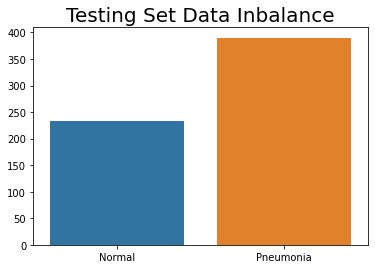


number of samples in dataset:
	 train_ds: 4173 val_ds: 1043
	 test_ds: 624


In [68]:
""" preparing the test dataset, create test dataloader, and print some information
""" 

data_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/dataset'

pneumonia_files_test = os.listdir(data_dir + "/test" + "/PNEUMONIA")
print('No. of test examples for Pneumonia:', len(pneumonia_files_test))
normal_files_test = os.listdir(data_dir + "/test" + "/NORMAL")
print('No. of test examples for Normal:', len(normal_files_test))

# define pre-processing steps on images
data_transorm_test = tt.Compose([tt.Resize(255),
                              tt.CenterCrop(224),                                                              
                              tt.ToTensor() 
                              ])

# create test dataset:
dataset_test = ImageFolder(data_dir + "/test", data_transorm_test)
print("classes in test dataset:",dataset_test.classes,"\n")
print("test dataset:","\n")
print(dataset_test)

# number of images for each class
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Testing Set Data Inbalance', fontsize=20)
plt.show()


# create dataloaders
batch_size_test=128
test_ds = dataset_test                     # just for consistency with the train,val name
print()
print("number of samples in dataset:")
print("\t", "train_ds:", len(train_ds), "val_ds:", len(val_ds)) 
print("\t", "test_ds:", len(test_ds))

test_dataloader = DataLoader(test_ds, batch_size=batch_size_test, shuffle=False)

# Train and Evaluate Model

## hyperparameters

In [69]:
"""parameters for the model intialization
"""
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
#       used when we tested different models.
#       model_name_options = ['efficientnet-b0', 'resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet']
model_name = 'efficientnet-b0'

# Use pretrained model
use_pretrained=True

# Flag for feature extracting. When False, we fine-tune the whole model,
#       when True we only update the reshaped layer params
feature_extract = True

# depth of model for efficientNets
#       used when we tested different versions.
versionLongefficientNets_options = [0,1,2,3,4]
versionLong = 1

"""parameters for model training:
"""
# Number of epochs to train for
num_epochs = 50

# learning rate:
#       used when we tested different learning rates.
#       learning_rate_options = [0.01, 0.001, 0.0001]
learning_rate = 0.001

# Setup the loss fn
#       weighted loss for data class imbalance
class_weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)])
criterion_ft = nn.CrossEntropyLoss(weight=class_weight).to(device)

## TMP SPLIT

### 1

In [70]:

"""
try 3 versions for comersion:
    initialize_model_3_relu
    initialize_model_3_LeakyRelu_noBatchNorm
    initialize_model_3_LeakyRelu_BatchNorm
    initialize_model_3_LeakyRelu_BatchNorm + scheduler
"""

'\ntry 3 versions for comersion:\n    initialize_model_3_relu\n    initialize_model_3_LeakyRelu_noBatchNorm\n    initialize_model_3_LeakyRelu_BatchNorm\n    initialize_model_3_LeakyRelu_BatchNorm + scheduler\n'

## initialize_model_3_relu

initialize_model parameters:
model_name: efficientnet-b0 use_pretrained: True feature_extract: True chooseLong: 3
Loaded pretrained weights for efficientnet-b0

Params to learn:
	 _fc.0.weight
	 _fc.0.bias
	 _fc.3.weight
	 _fc.3.bias
	 _fc.5.weight
	 _fc.5.bias
	 _fc.7.weight
	 _fc.7.bias
	 _fc.9.weight
	 _fc.9.bias
idx:1 model:efficientnet-b0 versionLong:3 lr:0.001

Epoch 0/49 |Train Loss: 0.2930 | Train Acc: 0.8893 |Val Loss: 1.6700 | Val Acc: 0.7603 | recall: 1.000 | precision: 0.760 | f1: 0.864 |Epoch Time: 427.61190962791443
Epoch 1/49 |Train Loss: 0.1989 | Train Acc: 0.9164 |Val Loss: 1.5741 | Val Acc: 0.7718 | recall: 1.000 | precision: 0.769 | f1: 0.869 |Epoch Time: 78.9263756275177
Epoch 2/49 |Train Loss: 0.1807 | Train Acc: 0.9260 |Val Loss: 0.5263 | Val Acc: 0.8802 | recall: 0.991 | precision: 0.869 | f1: 0.926 |Epoch Time: 79.08743977546692
Epoch 3/49 |Train Loss: 0.1528 | Train Acc: 0.9413 |Val Loss: 0.5401 | Val Acc: 0.9003 | recall: 0.995 | precision: 0.887 | f1: 0.938 |

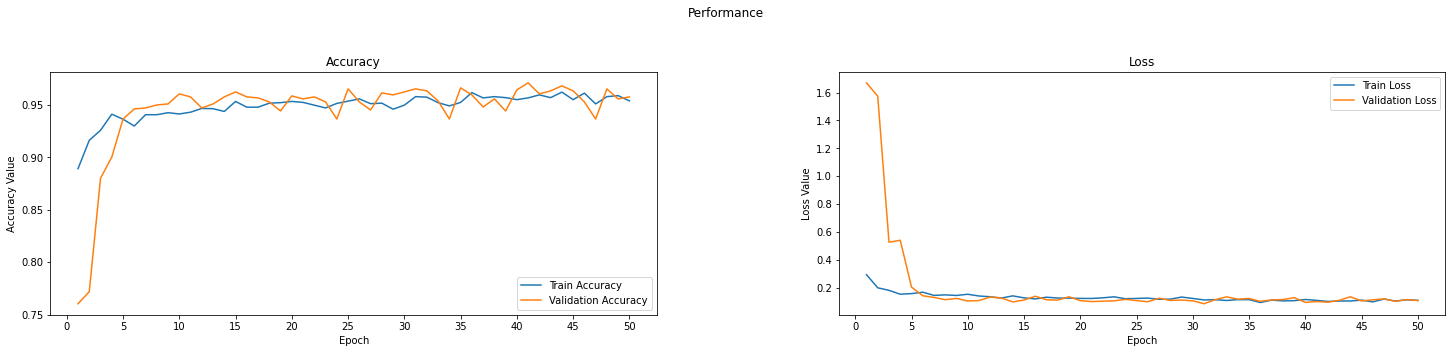

<Figure size 432x288 with 0 Axes>

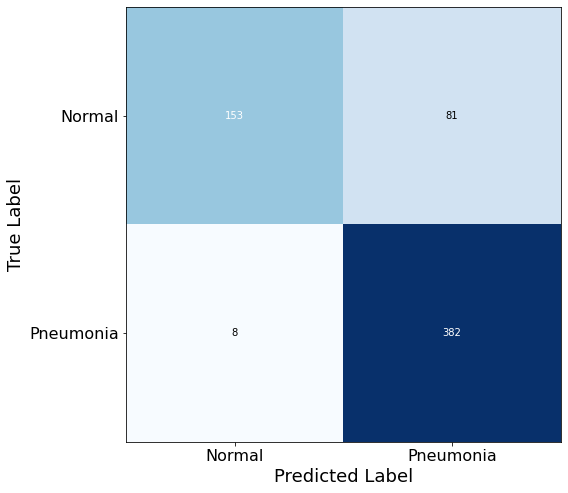


test accuracy: 0.857
Recall of the model is 0.979
Precision of the model is 0.825
F1 Score of the model is 0.896

==> Saving test results ...
checkpoint_dir: /content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND
checkpoint_test_path: /content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND/idx:1 model:efficientnet-b0 versionLong:3 lr:0.001time:2021-07-05_13:31__test_performance.pth

##################################################################################


In [71]:
idx = 0
for versionLong in [3]:
    idx = idx + 1
    """Initialize the model for this run
    """
    model_ft, _ = initialize_model_3_relu(model_name, use_pretrained, feature_extract, versionLong)

    # Print the model we just instantiated
    # print(model_ft) # shutdown whhile working

    model_ft = model_ft.to(device)
    print()
    """Create the Optimizer
    """

    # list of parameters to be optimized. check out the printed parameters to learn!
    params_to_update = gather_params_to_update(model_ft, feature_extract)
    # Observe that all parameters are being optimized
    optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate)


    # log:
    logParametersForTrain = "idx:{} model:{} versionLong:{} lr:{}".format(idx,model_name,versionLong,learning_rate)
    print(logParametersForTrain)
    print()

    """####################  Train and evaluate  ####################
    """
    model_ft, history_ft = train_model(model_ft, train_dataloader, val_dataloader, criterion_ft, optimizer_ft, num_epochs, device)
    print()

    """save training
    """
    timeToSave = getDateTimeString()
    checkpoint_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND'
    checkpoint_model_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__ckpt.pth'
    checkpoint_hist_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__hist.pth'
    print('==> Saving model ...')
    print("checkpoint_dir:", checkpoint_dir)
    print("checkpoint_model_path:", checkpoint_model_path)
    print("checkpoint_hist_path:" , checkpoint_hist_path)

    state_save = {
        'net': model_ft.state_dict(),
    }
    if not os.path.isdir(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    torch.save(state_save, checkpoint_model_path)
    torch.save(history_ft, checkpoint_hist_path)
    print()

    """Plot
    """
    # Plot Accuracy and Loss 
    print(logParametersForTrain)
    plot_acc_and_loss_for_train_and_val(history_ft)
    print() 
    """####################        Test         ####################
    """
    # Initialize the model for this run
    model_for_test, _ = initialize_model_3_relu(model_name, use_pretrained, feature_extract, versionLong)
    print()
    model_for_test = model_for_test.to(device)
    state_load = torch.load(checkpoint_model_path, map_location=device)
    model_for_test.load_state_dict(state_load['net'])
    print()
    # Test
    Performance_test = test_model(model_for_test, test_dataloader, device, True)
    print()
    # Print statisitcs
    print("test accuracy: {:.3f}".format(Performance_test['accuracy']))
    print("Recall of the model is {:.3f}".format(Performance_test['recall']))
    print("Precision of the model is {:.3f}".format(Performance_test['precision']))
    print("F1 Score of the model is {:.3f}".format(Performance_test['f1']))
    print()
    """save testing
    """
    timeToSave = getDateTimeString()
    checkpoint_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND'
    checkpoint_test_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__test_performance.pth'
    print('==> Saving test results ...')
    print("checkpoint_dir:", checkpoint_dir)
    print("checkpoint_test_path:", checkpoint_test_path)

    torch.save(Performance_test, checkpoint_test_path)

    print()
    print("##################################################################################")

## initialize_model_3_LeakyRelu_noBatchNorm

initialize_model parameters:
model_name: efficientnet-b0 use_pretrained: True feature_extract: True chooseLong: 3
Loaded pretrained weights for efficientnet-b0

Params to learn:
	 _fc.0.weight
	 _fc.0.bias
	 _fc.3.weight
	 _fc.3.bias
	 _fc.5.weight
	 _fc.5.bias
	 _fc.7.weight
	 _fc.7.bias
	 _fc.9.weight
	 _fc.9.bias
idx:1 model:efficientnet-b0 versionLong:3 lr:0.001

Epoch 0/49 |Train Loss: 0.3000 | Train Acc: 0.8821 |Val Loss: 1.6621 | Val Acc: 0.7593 | recall: 1.000 | precision: 0.759 | f1: 0.863 |Epoch Time: 80.03009986877441
Epoch 1/49 |Train Loss: 0.1929 | Train Acc: 0.9171 |Val Loss: 0.5265 | Val Acc: 0.8600 | recall: 0.961 | precision: 0.869 | f1: 0.912 |Epoch Time: 81.36282753944397
Epoch 2/49 |Train Loss: 0.1703 | Train Acc: 0.9226 |Val Loss: 0.4382 | Val Acc: 0.8897 | recall: 0.984 | precision: 0.884 | f1: 0.931 |Epoch Time: 80.60408592224121
Epoch 3/49 |Train Loss: 0.1645 | Train Acc: 0.9317 |Val Loss: 0.7680 | Val Acc: 0.8591 | recall: 0.996 | precision: 0.846 | f1: 0.915 |

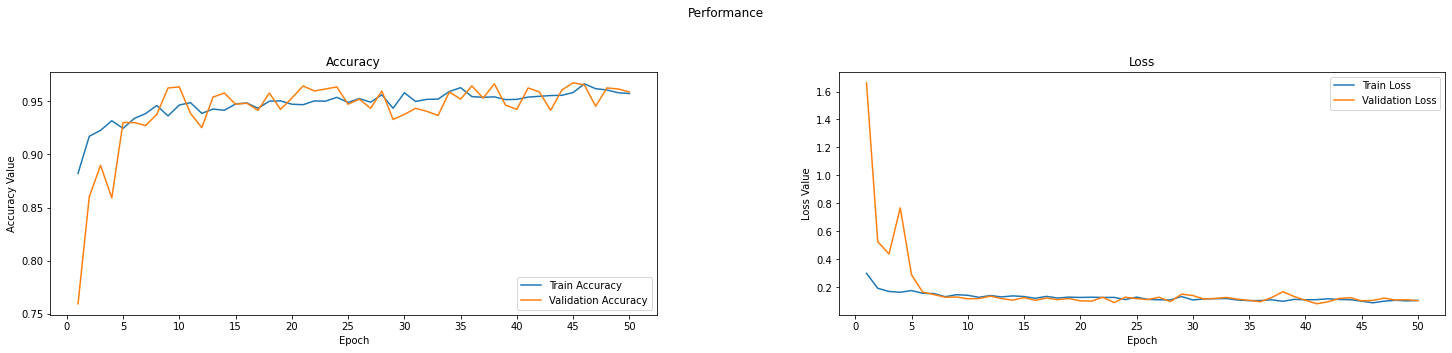

<Figure size 432x288 with 0 Axes>

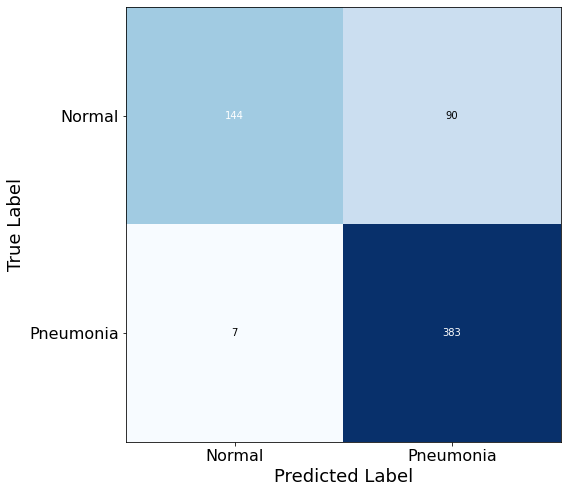


test accuracy: 0.845
Recall of the model is 0.982
Precision of the model is 0.810
F1 Score of the model is 0.888

==> Saving test results ...
checkpoint_dir: /content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND
checkpoint_test_path: /content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND/idx:1 model:efficientnet-b0 versionLong:3 lr:0.001time:2021-07-05_14:37__test_performance.pth

##################################################################################


In [72]:
idx = 0
for versionLong in [3]:
    idx = idx + 1
    """Initialize the model for this run
    """
    model_ft, _ = initialize_model_3_LeakyRelu_noBatchNorm(model_name, use_pretrained, feature_extract, versionLong)

    # Print the model we just instantiated
    # print(model_ft) # shutdown whhile working

    model_ft = model_ft.to(device)
    print()
    """Create the Optimizer
    """

    # list of parameters to be optimized. check out the printed parameters to learn!
    params_to_update = gather_params_to_update(model_ft, feature_extract)
    # Observe that all parameters are being optimized
    optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate)

    

    # log:
    logParametersForTrain = "idx:{} model:{} versionLong:{} lr:{}".format(idx,model_name,versionLong,learning_rate)
    print(logParametersForTrain)
    print()

    """####################  Train and evaluate  ####################
    """
    model_ft, history_ft = train_model(model_ft, train_dataloader, val_dataloader, criterion_ft, optimizer_ft, num_epochs, device)
    print()

    """save training
    """
    timeToSave = getDateTimeString()
    checkpoint_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND'
    checkpoint_model_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__ckpt.pth'
    checkpoint_hist_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__hist.pth'
    print('==> Saving model ...')
    print("checkpoint_dir:", checkpoint_dir)
    print("checkpoint_model_path:", checkpoint_model_path)
    print("checkpoint_hist_path:" , checkpoint_hist_path)

    state_save = {
        'net': model_ft.state_dict(),
    }
    if not os.path.isdir(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    torch.save(state_save, checkpoint_model_path)
    torch.save(history_ft, checkpoint_hist_path)
    print()

    """Plot
    """
    # Plot Accuracy and Loss 
    print(logParametersForTrain)
    plot_acc_and_loss_for_train_and_val(history_ft)
    print() 
    """####################        Test         ####################
    """
    # Initialize the model for this run
    model_for_test, _ = initialize_model_3_LeakyRelu_noBatchNorm(model_name, use_pretrained, feature_extract, versionLong)
    print()
    model_for_test = model_for_test.to(device)
    state_load = torch.load(checkpoint_model_path, map_location=device)
    model_for_test.load_state_dict(state_load['net'])
    print()
    # Test
    Performance_test = test_model(model_for_test, test_dataloader, device, True)
    print()
    # Print statisitcs
    print("test accuracy: {:.3f}".format(Performance_test['accuracy']))
    print("Recall of the model is {:.3f}".format(Performance_test['recall']))
    print("Precision of the model is {:.3f}".format(Performance_test['precision']))
    print("F1 Score of the model is {:.3f}".format(Performance_test['f1']))
    print()
    """save testing
    """
    timeToSave = getDateTimeString()
    checkpoint_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND'
    checkpoint_test_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__test_performance.pth'
    print('==> Saving test results ...')
    print("checkpoint_dir:", checkpoint_dir)
    print("checkpoint_test_path:", checkpoint_test_path)

    torch.save(Performance_test, checkpoint_test_path)

    print()
    print("##################################################################################")

## initialize_model_3_LeakyRelu_BatchNorm

initialize_model parameters:
model_name: efficientnet-b0 use_pretrained: True feature_extract: True chooseLong: 3
Loaded pretrained weights for efficientnet-b0

Params to learn:
	 _fc.0.weight
	 _fc.0.bias
	 _fc.3.weight
	 _fc.3.bias
	 _fc.4.weight
	 _fc.4.bias
	 _fc.6.weight
	 _fc.6.bias
	 _fc.8.weight
	 _fc.8.bias
	 _fc.9.weight
	 _fc.9.bias
	 _fc.11.weight
	 _fc.11.bias
idx:1 model:efficientnet-b0 versionLong:3 lr:0.001

Epoch 0/49 |Train Loss: 0.2698 | Train Acc: 0.8850 |Val Loss: 1.5332 | Val Acc: 0.7593 | recall: 1.000 | precision: 0.759 | f1: 0.863 |Epoch Time: 80.26574993133545
Epoch 1/49 |Train Loss: 0.1925 | Train Acc: 0.9185 |Val Loss: 0.9985 | Val Acc: 0.8121 | recall: 0.992 | precision: 0.805 | f1: 0.889 |Epoch Time: 80.52363848686218
Epoch 2/49 |Train Loss: 0.1821 | Train Acc: 0.9216 |Val Loss: 0.5136 | Val Acc: 0.8869 | recall: 0.984 | precision: 0.881 | f1: 0.930 |Epoch Time: 80.30421233177185
Epoch 3/49 |Train Loss: 0.1697 | Train Acc: 0.9310 |Val Loss: 0.4093 | Val Ac

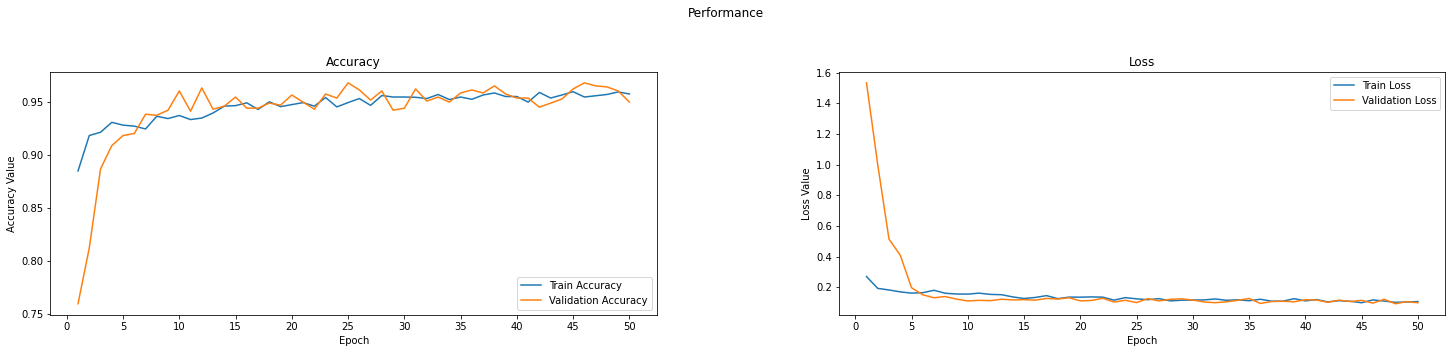

<Figure size 432x288 with 0 Axes>

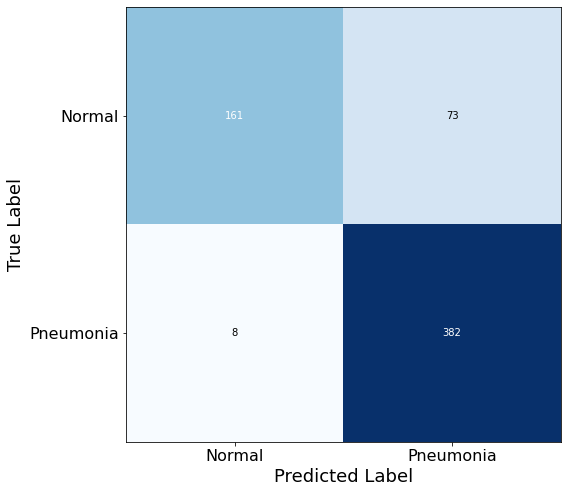


test accuracy: 0.870
Recall of the model is 0.979
Precision of the model is 0.840
F1 Score of the model is 0.904

==> Saving test results ...
checkpoint_dir: /content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND
checkpoint_test_path: /content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND/idx:1 model:efficientnet-b0 versionLong:3 lr:0.001time:2021-07-05_15:45__test_performance.pth

##################################################################################


In [73]:
idx = 0
for versionLong in [3]:
    idx = idx + 1
    """Initialize the model for this run
    """
    model_ft, _ = initialize_model_3_LeakyRelu_BatchNorm(model_name, use_pretrained, feature_extract, versionLong)

    # Print the model we just instantiated
    # print(model_ft) # shutdown whhile working

    model_ft = model_ft.to(device)
    print()
    """Create the Optimizer
    """

    # list of parameters to be optimized. check out the printed parameters to learn!
    params_to_update = gather_params_to_update(model_ft, feature_extract)
    # Observe that all parameters are being optimized
    optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate)


    

    # log:
    logParametersForTrain = "idx:{} model:{} versionLong:{} lr:{}".format(idx,model_name,versionLong,learning_rate)
    print(logParametersForTrain)
    print()

    """####################  Train and evaluate  ####################
    """
    model_ft, history_ft = train_model(model_ft, train_dataloader, val_dataloader, criterion_ft, optimizer_ft, num_epochs, device)
    print()

    """save training
    """
    timeToSave = getDateTimeString()
    checkpoint_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND'
    checkpoint_model_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__ckpt.pth'
    checkpoint_hist_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__hist.pth'
    print('==> Saving model ...')
    print("checkpoint_dir:", checkpoint_dir)
    print("checkpoint_model_path:", checkpoint_model_path)
    print("checkpoint_hist_path:" , checkpoint_hist_path)

    state_save = {
        'net': model_ft.state_dict(),
    }
    if not os.path.isdir(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    torch.save(state_save, checkpoint_model_path)
    torch.save(history_ft, checkpoint_hist_path)
    print()

    """Plot
    """
    # Plot Accuracy and Loss 
    print(logParametersForTrain)
    plot_acc_and_loss_for_train_and_val(history_ft)
    print() 
    """####################        Test         ####################
    """
    # Initialize the model for this run
    model_for_test, _ = initialize_model_3_LeakyRelu_BatchNorm(model_name, use_pretrained, feature_extract, versionLong)
    print()
    model_for_test = model_for_test.to(device)
    state_load = torch.load(checkpoint_model_path, map_location=device)
    model_for_test.load_state_dict(state_load['net'])
    print()
    # Test
    Performance_test = test_model(model_for_test, test_dataloader, device, True)
    print()
    # Print statisitcs
    print("test accuracy: {:.3f}".format(Performance_test['accuracy']))
    print("Recall of the model is {:.3f}".format(Performance_test['recall']))
    print("Precision of the model is {:.3f}".format(Performance_test['precision']))
    print("F1 Score of the model is {:.3f}".format(Performance_test['f1']))
    print()
    """save testing
    """
    timeToSave = getDateTimeString()
    checkpoint_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND'
    checkpoint_test_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__test_performance.pth'
    print('==> Saving test results ...')
    print("checkpoint_dir:", checkpoint_dir)
    print("checkpoint_test_path:", checkpoint_test_path)

    torch.save(Performance_test, checkpoint_test_path)

    print()
    print("##################################################################################")

## initialize_model_3_LeakyRelu_BatchNorm + scheduler

initialize_model parameters:
model_name: efficientnet-b0 use_pretrained: True feature_extract: True chooseLong: 3
Loaded pretrained weights for efficientnet-b0

Params to learn:
	 _fc.0.weight
	 _fc.0.bias
	 _fc.3.weight
	 _fc.3.bias
	 _fc.5.weight
	 _fc.5.bias
	 _fc.7.weight
	 _fc.7.bias
	 _fc.9.weight
	 _fc.9.bias
idx:1 model:efficientnet-b0 versionLong:3 lr:0.001

Epoch 0/49 |Train Loss: 0.2881 | Train Acc: 0.8917 |Val Loss: 1.9054 | Val Acc: 0.7593 | recall: 1.000 | precision: 0.759 | f1: 0.863 |Epoch Time: 80.26704692840576
Epoch 1/49 |Train Loss: 0.1835 | Train Acc: 0.9264 |Val Loss: 0.9080 | Val Acc: 0.8111 | recall: 0.994 | precision: 0.804 | f1: 0.889 |Epoch Time: 80.0274806022644
Epoch 2/49 |Train Loss: 0.1812 | Train Acc: 0.9248 |Val Loss: 0.5587 | Val Acc: 0.8639 | recall: 0.996 | precision: 0.850 | f1: 0.917 |Epoch Time: 80.03657937049866
Epoch 3/49 |Train Loss: 0.1473 | Train Acc: 0.9442 |Val Loss: 0.6420 | Val Acc: 0.8677 | recall: 0.992 | precision: 0.856 | f1: 0.919 |E

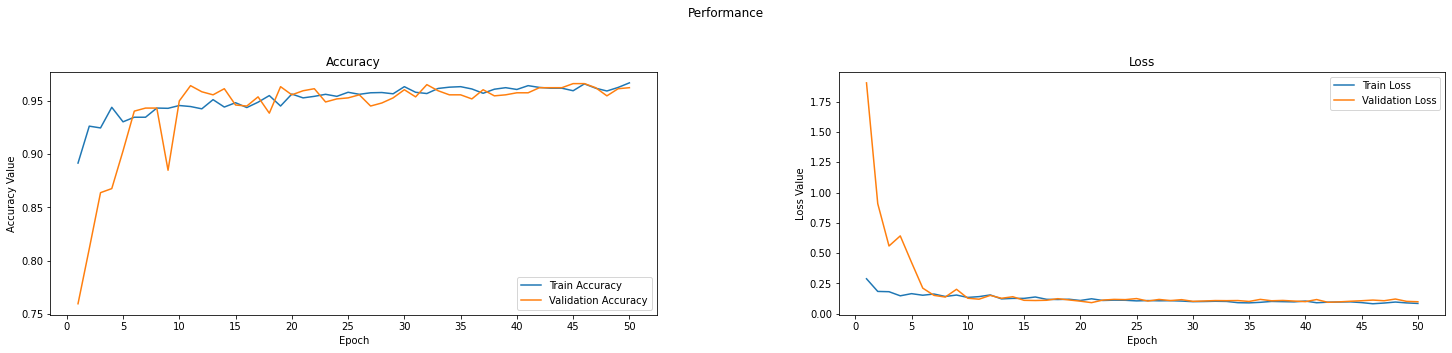

<Figure size 432x288 with 0 Axes>

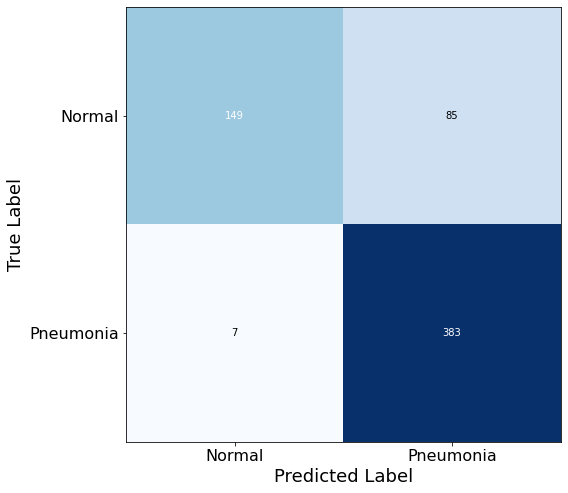


test accuracy: 0.853
Recall of the model is 0.982
Precision of the model is 0.818
F1 Score of the model is 0.893

==> Saving test results ...
checkpoint_dir: /content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND
checkpoint_test_path: /content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND/idx:1 model:efficientnet-b0 versionLong:3 lr:0.001time:2021-07-05_16:52__test_performance.pth

##################################################################################


In [74]:
idx = 0
for versionLong in [3]:
    idx = idx + 1
    """Initialize the model for this run
    """
    model_ft, _ = initialize_model_3_relu(model_name, use_pretrained, feature_extract, versionLong)

    # Print the model we just instantiated
    # print(model_ft) # shutdown whhile working

    model_ft = model_ft.to(device)
    print()
    """Create the Optimizer
    """

    # list of parameters to be optimized. check out the printed parameters to learn!
    params_to_update = gather_params_to_update(model_ft, feature_extract)
    # Observe that all parameters are being optimized
    optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate)

    # INSTANTIATE STEP LEARNING SCHEDULER CLASS:
    factor_ft=0.7
    patience_ft=4
    scheduler_ft = ReduceLROnPlateau(optimizer_ft, mode='max', factor=factor_ft, patience=patience_ft, verbose=True)
    

    # log:
    logParametersForTrain = "idx:{} model:{} versionLong:{} lr:{}".format(idx,model_name,versionLong,learning_rate)
    print(logParametersForTrain)
    print()

    """####################  Train and evaluate  ####################
    """
    model_ft, history_ft = train_model_with_scheduler(model_ft, train_dataloader, val_dataloader, criterion_ft, optimizer_ft,scheduler_ft, num_epochs, device)
    print()

    """save training
    """
    timeToSave = getDateTimeString()
    checkpoint_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND'
    checkpoint_model_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__ckpt.pth'
    checkpoint_hist_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__hist.pth'
    print('==> Saving model ...')
    print("checkpoint_dir:", checkpoint_dir)
    print("checkpoint_model_path:", checkpoint_model_path)
    print("checkpoint_hist_path:" , checkpoint_hist_path)

    state_save = {
        'net': model_ft.state_dict(),
    }
    if not os.path.isdir(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    torch.save(state_save, checkpoint_model_path)
    torch.save(history_ft, checkpoint_hist_path)
    print()

    """Plot
    """
    # Plot Accuracy and Loss 
    print(logParametersForTrain)
    plot_acc_and_loss_for_train_and_val(history_ft)
    print() 
    """####################        Test         ####################
    """
    # Initialize the model for this run
    model_for_test, _ = initialize_model_3_relu(model_name, use_pretrained, feature_extract, versionLong)
    print()
    model_for_test = model_for_test.to(device)
    state_load = torch.load(checkpoint_model_path, map_location=device)
    model_for_test.load_state_dict(state_load['net'])
    print()
    # Test
    Performance_test = test_model(model_for_test, test_dataloader, device, True)
    print()
    # Print statisitcs
    print("test accuracy: {:.3f}".format(Performance_test['accuracy']))
    print("Recall of the model is {:.3f}".format(Performance_test['recall']))
    print("Precision of the model is {:.3f}".format(Performance_test['precision']))
    print("F1 Score of the model is {:.3f}".format(Performance_test['f1']))
    print()
    """save testing
    """
    timeToSave = getDateTimeString()
    checkpoint_dir = '/content/drive/MyDrive/DL/project_ariel_yael/pneumonia/checkpoints_pneumonia_ACC_COND'
    checkpoint_test_path = checkpoint_dir + '/' + logParametersForTrain + timeToSave + '__test_performance.pth'
    print('==> Saving test results ...')
    print("checkpoint_dir:", checkpoint_dir)
    print("checkpoint_test_path:", checkpoint_test_path)

    torch.save(Performance_test, checkpoint_test_path)

    print()
    print("##################################################################################")